# **SME0828 - Introdução à Ciência de Dados**

# **Projeto Final - Uso de classificadores para prever o diagnóstico de diabetes**

**Gustavo Andrade Tavares** N°USP: 11212362


Universidade de São Paulo, São Carlos, Brasil.

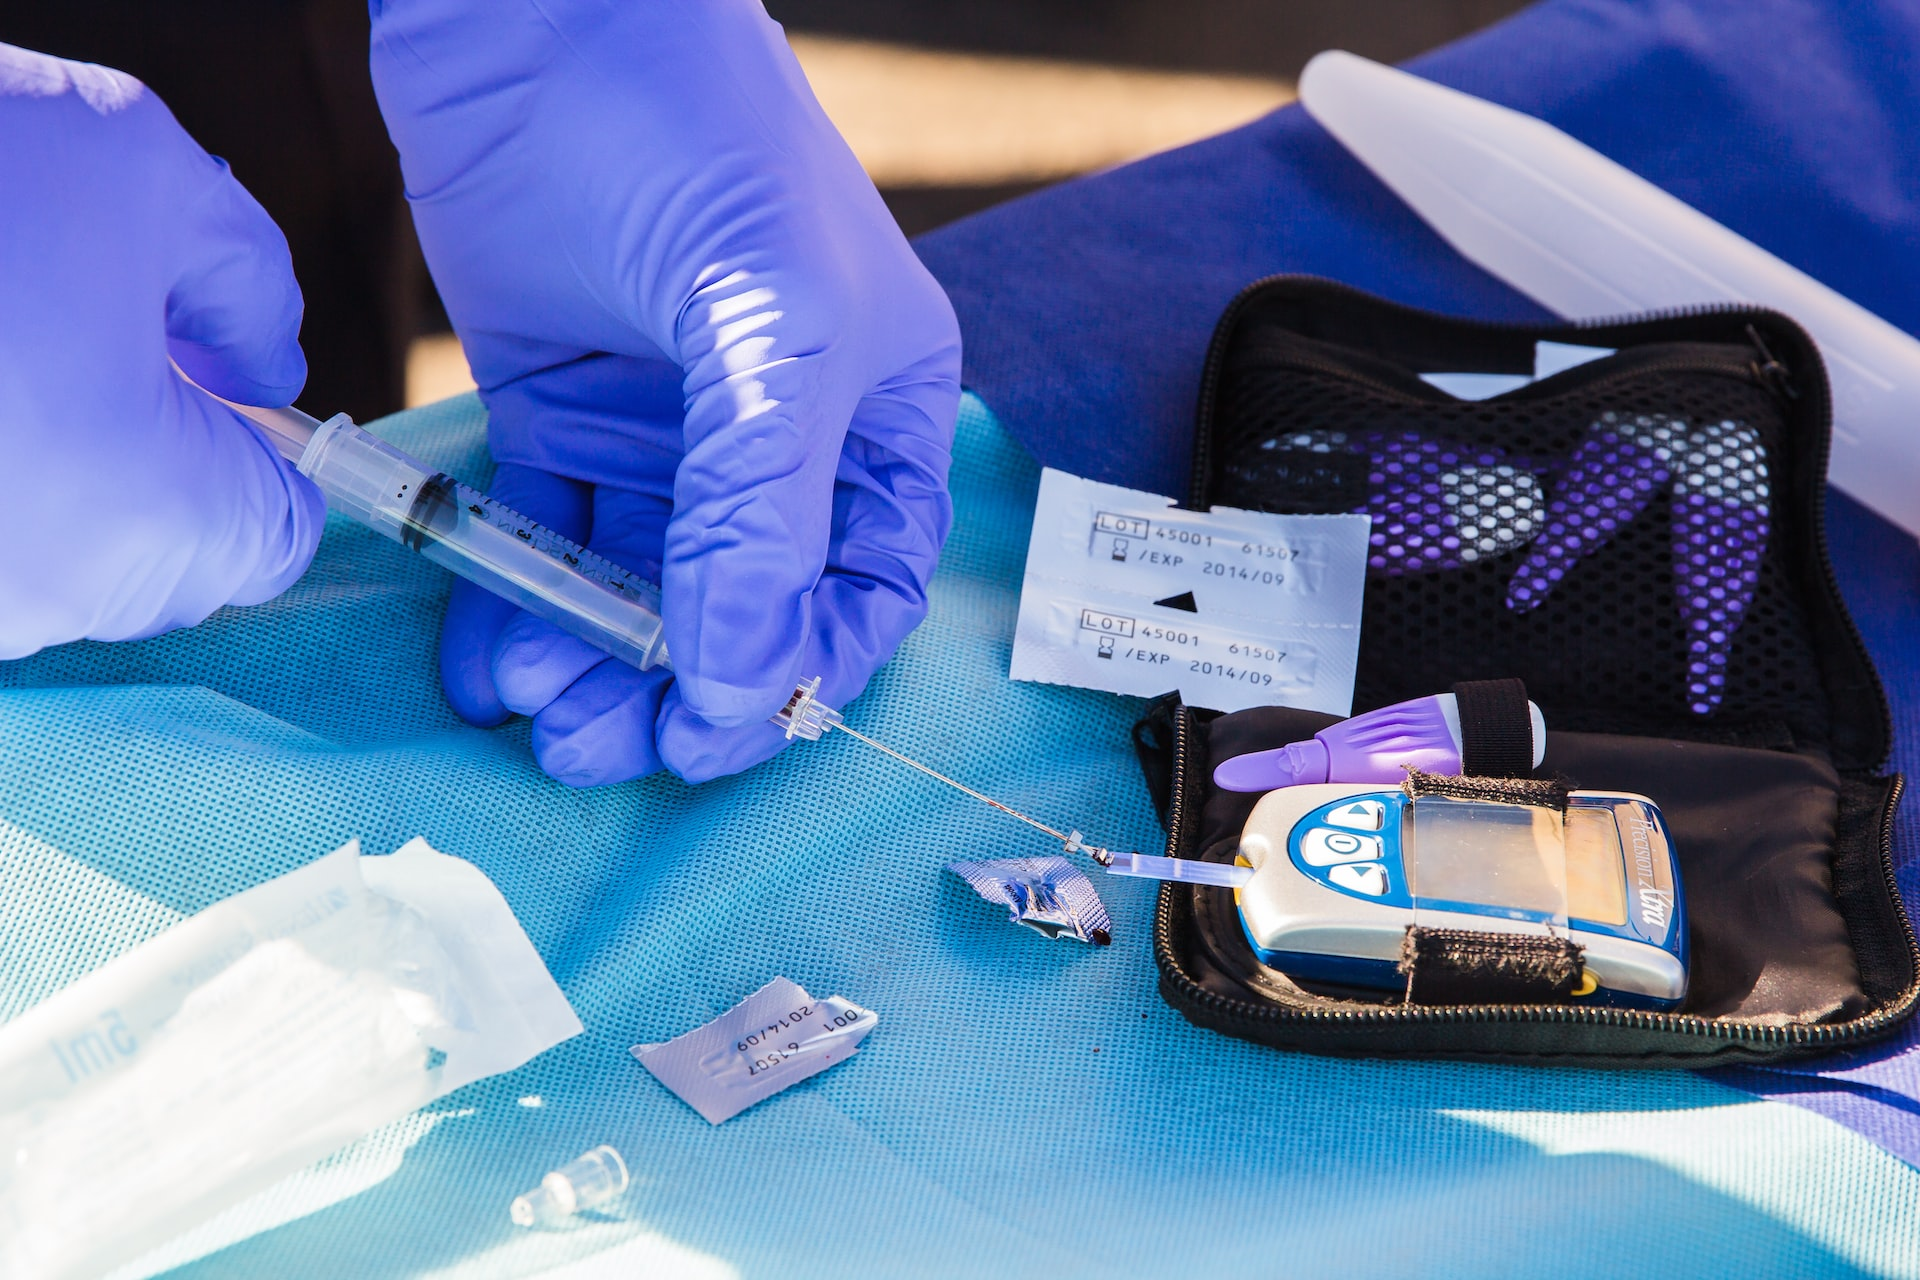

<center>Photo by <a href="https://unsplash.com/@mchesin?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Matt C</a> on <a href="https://unsplash.com/photos/bRjpGjwmae8?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a><center/>
  

## **1) Introdução**

Diabetes é um grupo de doenças metabólicas em que se verificam níveis elevados de glicose no sangue durante um longo intervalo de tempo. Quando não é tratada, a diabetes pode causar várias complicações, tais como cetoacidose, coma hiperosmolar hiperglicémico ou morte. Estima-se que em 2015 cerca de 415 milhões de pessoas em todo o mundo tinham diabetes. Além disso, entre 2012 e 2015, a diabetes foi a causa de 1,5 a 5 milhões de mortes anuais.

Neste trabalho, aplicamos conceitos de estatística, ciência de dados e aprendizado de máquina para prever diagnósticos de diabetes.

A base de dados que utilizamos contém informações de 768 pacientes, cada um com 9 variáveis:




*   Pregnancies: número de vezes que a pessoa engravidou;
*   Glucose: nível de glicose no sangue;
*   BloodPressure: pressão sanguínea;
*   SkinThickness: espessura da pele;
*   Insulin: nível de insulina no sangue;
*   BMI: índice de massa corporal;
*   DiabetesPedigreeFunction: função que quantifica o risco de diabetes baseado em fatores hereditários;
*   Age: idade;
*   Outcome: diagnóstico para diabetes (0 - Negativo; 1 - Positivo).

Sendo assim, o objetivo é fazer previsões de casos de diabetes utilizando métodos de classificação.



## **2) Bibliotecas**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.model_selection import GridSearchCV

## **3) Preparação dos Dados**

Lendo o arquivo csv que contém a base de dados:

In [ ]:
diabetes = pd.read_csv("https://raw.githubusercontent.com/gustavo-andrade-tavares/Datasets/main/diabetes.csv")
diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Antes de realizarmos qualquer alteração nos dados, como substituição de valores ou padronização, iremos dividir a base em conjuntos de treinamento e teste, a fim de evitar vazamento de informação de um para o outro. Tal vazamento poderia afetar a avaliação dos classificadores que queremos ajustar.

In [ ]:
data_diabetes = diabetes.to_numpy()
nrow,ncol = data_diabetes.shape
y = data_diabetes[:,-1]
X = data_diabetes[:,0:ncol-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state= 42)

Assim, as dimensões de cada conjunto é dada por:

In [ ]:
print("Treinamento: ", X_train.shape)
print("Teste: ", X_test.shape)

Treinamento:  (576, 8)
Teste:  (192, 8)


Transformando-se os dois conjuntos de dados em dataframe, temos:

In [ ]:
colunas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df_Xtrain = pd.DataFrame(X_train, columns=colunas)
df_Xtrain.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,13.0,129.0,0.0,30.0,0.0,39.9,0.569,44.0
1,4.0,129.0,86.0,20.0,270.0,35.1,0.231,23.0
2,3.0,61.0,82.0,28.0,0.0,34.4,0.243,46.0
3,2.0,81.0,72.0,15.0,76.0,30.1,0.547,25.0
4,0.0,102.0,75.0,23.0,0.0,0.0,0.572,21.0


In [ ]:
df_ytrain = pd.DataFrame(y_train, columns = ["Outcome"])
df_ytrain.head()

,Outcome
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0


Juntando-se os dois anteriores, obtém-se o conjunto de treinamento original:

In [ ]:
train_original = df_Xtrain.join(df_ytrain)
train_original.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,13.0,129.0,0.0,30.0,0.0,39.9,0.569,44.0,1.0
1,4.0,129.0,86.0,20.0,270.0,35.1,0.231,23.0,0.0
2,3.0,61.0,82.0,28.0,0.0,34.4,0.243,46.0,0.0
3,2.0,81.0,72.0,15.0,76.0,30.1,0.547,25.0,0.0
4,0.0,102.0,75.0,23.0,0.0,0.0,0.572,21.0,0.0


Fazendo-se o mesmo para o conjunto de teste, temos:

In [ ]:
colunas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df_Xtest = pd.DataFrame(X_test, columns=colunas)
df_Xtest.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,98.0,58.0,33.0,190.0,34.0,0.430,43.0
1,2.0,112.0,75.0,32.0,0.0,35.7,0.148,21.0
2,2.0,108.0,64.0,0.0,0.0,30.8,0.158,21.0
3,8.0,107.0,80.0,0.0,0.0,24.6,0.856,34.0
4,7.0,136.0,90.0,0.0,0.0,29.9,0.210,50.0


In [ ]:
df_ytest = pd.DataFrame(y_test, columns = ["Outcome"])
df_ytest.head()

,Outcome
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


Assim, obtém-se o conjunto de teste original:

In [ ]:
test_original = df_Xtest.join(df_ytest)
test_original.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,98.0,58.0,33.0,190.0,34.0,0.430,43.0,0.0
1,2.0,112.0,75.0,32.0,0.0,35.7,0.148,21.0,0.0
2,2.0,108.0,64.0,0.0,0.0,30.8,0.158,21.0,0.0
3,8.0,107.0,80.0,0.0,0.0,24.6,0.856,34.0,0.0
4,7.0,136.0,90.0,0.0,0.0,29.9,0.210,50.0,0.0


A variável Outcome foi incluída no conjunto de teste apenas por conveniência. Sendo assim, ao utilizar o conjunto de teste nos métodos de classificação, será necessário removê-la. Assim, com a variável Outcome separada do conjunto de teste, é possível utilizá-la como $y_{true}$. Isto é, após fazer a classificação, é possível comparar os valores preditos $y_{pred}$ com os valores verdadeiros $y_{true}$.

Sendo assim, será possível obter falsos negativos (FN), falsos positivos (FP), verdadeiros negativos (VN) e verdadeiros positivos (VP).

Agora, é necessário verificar se há valores faltantes nos dois conjuntos de dados, com isso, temos:

In [ ]:
train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               576 non-null    float64
 1   Glucose                   576 non-null    float64
 2   BloodPressure             576 non-null    float64
 3   SkinThickness             576 non-null    float64
 4   Insulin                   576 non-null    float64
 5   BMI                       576 non-null    float64
 6   DiabetesPedigreeFunction  576 non-null    float64
 7   Age                       576 non-null    float64
 8   Outcome                   576 non-null    float64
dtypes: float64(9)
memory usage: 40.6 KB


Inicialmente, nota-se que não há valores NaN. Assim, visualizando-se o comportamento dos dados, segue que:

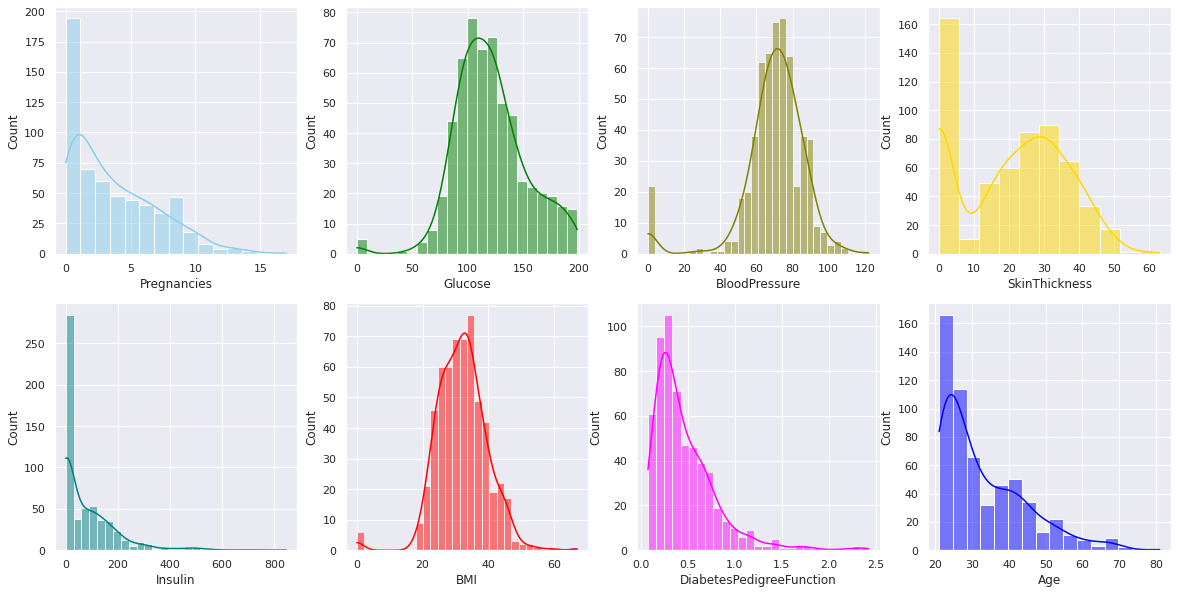

In [ ]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(data=train_original, x="Pregnancies", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=train_original, x="Glucose", kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=train_original, x="BloodPressure", kde=True, color="olive", ax=axs[0, 2])
sns.histplot(data=train_original, x="SkinThickness", kde=True, color="gold", ax=axs[0, 3])
sns.histplot(data=train_original, x="Insulin", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=train_original, x="BMI", kde=True, color="red", ax=axs[1, 1])
sns.histplot(data=train_original, x="DiabetesPedigreeFunction", kde=True, color="magenta", ax=axs[1, 2])
sns.histplot(data=train_original, x="Age", kde=True, color="blue", ax=axs[1, 3])

plt.show()

Pela análise dos histogramas, nota-se a presença de muitas observações com valores iguais a zero. Entretanto, para algumas variáveis estas observações com valor zero não fazem sentido. Por exemplo: um BMI igual a zero indica que a pessoa pesa 0 kg e uma pressão sanguínea igual a zero indica que a pessoa não tem sangue circulando em seus vasos sanguíneos!

Claramente, estes valores sem sentido são na verdade valores faltantes na base de dados que deverão ser corrigidos.

Assim, verificando-se o número de valores iguais a zero, temos:

In [ ]:
a = train_original.Pregnancies.tolist()
b = train_original.Glucose.tolist()
c = train_original.BloodPressure.tolist()
d = train_original.SkinThickness.tolist()
e = train_original.Insulin.tolist()
f = train_original.BMI.tolist()
g = train_original.DiabetesPedigreeFunction.tolist()
h = train_original.Age.tolist()

print("Número de zeros de Pregnancies: ",a.count(0))
print("Número de zeros de Glucose: ",b.count(0))
print("Número de zeros de BloodPressure: ",c.count(0))
print("Número de zeros de SkinThickness: ",d.count(0))
print("Número de zeros de Insulin: ",e.count(0))
print("Número de zeros de BMI: ",f.count(0))
print("Número de zeros de DiabetesPedigreeFunction: ",g.count(0))
print("Número de zeros de Age: ",h.count(0))

Número de zeros de Pregnancies:  86
Número de zeros de Glucose:  5
Número de zeros de BloodPressure:  22
Número de zeros de SkinThickness:  164
Número de zeros de Insulin:  276
Número de zeros de BMI:  6
Número de zeros de DiabetesPedigreeFunction:  0
Número de zeros de Age:  0


Agora, verificando-se o conjunto de teste, segue que:

In [ ]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               192 non-null    float64
 1   Glucose                   192 non-null    float64
 2   BloodPressure             192 non-null    float64
 3   SkinThickness             192 non-null    float64
 4   Insulin                   192 non-null    float64
 5   BMI                       192 non-null    float64
 6   DiabetesPedigreeFunction  192 non-null    float64
 7   Age                       192 non-null    float64
 8   Outcome                   192 non-null    float64
dtypes: float64(9)
memory usage: 13.6 KB


Semelhantemente ao caso anterior, observa-se o comportamento dos dados:

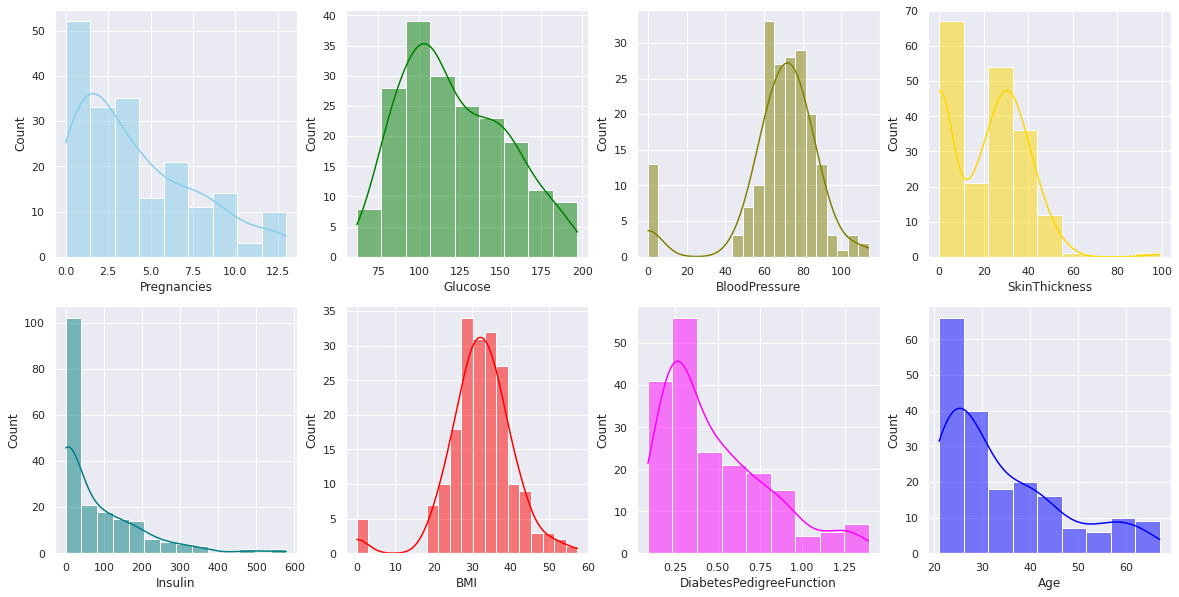

In [ ]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(data=test_original, x="Pregnancies", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=test_original, x="Glucose", kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=test_original, x="BloodPressure", kde=True, color="olive", ax=axs[0, 2])
sns.histplot(data=test_original, x="SkinThickness", kde=True, color="gold", ax=axs[0, 3])
sns.histplot(data=test_original, x="Insulin", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=test_original, x="BMI", kde=True, color="red", ax=axs[1, 1])
sns.histplot(data=test_original, x="DiabetesPedigreeFunction", kde=True, color="magenta", ax=axs[1, 2])
sns.histplot(data=test_original, x="Age", kde=True, color="blue", ax=axs[1, 3])

plt.show()

Da mesma forma que com o conjunto de treinamento, também há muitos valores iguais a zero que não tem sentido no conjunto de teste. Deverão ser corrigidos.

In [ ]:
a = test_original.Pregnancies.tolist()
b = test_original.Glucose.tolist()
c = test_original.BloodPressure.tolist()
d = test_original.SkinThickness.tolist()
e = test_original.Insulin.tolist()
f = test_original.BMI.tolist()
g = test_original.DiabetesPedigreeFunction.tolist()
h = test_original.Age.tolist()

print("Número de zeros de Pregnancies: ",a.count(0))
print("Número de zeros de Glucose: ",b.count(0))
print("Número de zeros de BloodPressure: ",c.count(0))
print("Número de zeros de SkinThickness: ",d.count(0))
print("Número de zeros de Insulin: ",e.count(0))
print("Número de zeros de BMI: ",f.count(0))
print("Número de zeros de DiabetesPedigreeFunction: ",g.count(0))
print("Número de zeros de Age: ",h.count(0))

Número de zeros de Pregnancies:  25
Número de zeros de Glucose:  0
Número de zeros de BloodPressure:  13
Número de zeros de SkinThickness:  63
Número de zeros de Insulin:  98
Número de zeros de BMI:  5
Número de zeros de DiabetesPedigreeFunction:  0
Número de zeros de Age:  0


Sendo assim, para os dois conjuntos de dados, é necessário fazer o preenchimento desses valores iguais a zero para algumas das variáveis. Apesar da variável insulina possuir muitos valores iguais a zero, não iremos mudar estes. Como a condição de diabetes está associada a uma deficiência do pâncreas de produzir insulina, decidimos não alterar estes valores devido à sua importância no diagnóstico médico.

Por outro lado, iremos considerar como dados faltantes os casos em que os valores das variáveis glicose, pressão sanguínea, espessura da pele e BMI sejam iguais a zero 

### **3.1) Preenchimento de valores faltantes para o conjunto de treinamento**

Tentaremos substituir valores faltantes por regressão linear. Para isto, primeiro precisamos normalizar os dados, tanto do conjunto de teste quanto do conjunto de treinamento. Isto é necessário, pois as oito variáveis numéricas variam em escalas diferentes.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
pregnancies = np.array(train_original[train_original.columns[0]])
pregnancies_norm = scaler.fit_transform(pregnancies.reshape(-1,1))

glucose = np.array(train_original[train_original.columns[1]])
glucose_norm = scaler.fit_transform(glucose.reshape(-1,1))

bloodpressure = np.array(train_original[train_original.columns[2]])
bloodpressure_norm = scaler.fit_transform(bloodpressure.reshape(-1,1))

skinthickness = np.array(train_original[train_original.columns[3]])
skinthickness_norm = scaler.fit_transform(skinthickness.reshape(-1,1))

insulin = np.array(train_original[train_original.columns[4]])
insulin_norm = scaler.fit_transform(insulin.reshape(-1,1))

bmi = np.array(train_original[train_original.columns[5]])
bmi_norm = scaler.fit_transform(bmi.reshape(-1,1))

diabetesfunction = np.array(train_original[train_original.columns[6]])
diabetesfunction_norm = scaler.fit_transform(diabetesfunction.reshape(-1,1))

age = np.array(train_original[train_original.columns[7]])
age_norm = scaler.fit_transform(age.reshape(-1,1))

In [ ]:
train_norm = train_original.copy()

for i in range(train_original.shape[0]):
  train_norm.loc[i,'Pregnancies'] = pregnancies_norm[i]
  train_norm.loc[i,'Glucose'] = glucose_norm[i]
  train_norm.loc[i,'BloodPressure'] = bloodpressure_norm[i]
  train_norm.loc[i,'SkinThickness'] = skinthickness_norm[i]
  train_norm.loc[i,'Insulin'] = insulin_norm[i]  
  train_norm.loc[i,'BMI'] = bmi_norm[i]  
  train_norm.loc[i,'DiabetesPedigreeFunction'] = diabetesfunction_norm[i]  
  train_norm.loc[i,'Age'] = age_norm[i]  

print("Dataframe do conjunto de treino normalizado")
train_norm.head(10)

Dataframe do conjunto de treino normalizado


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.764706,0.648241,0.000000,0.476190,0.000000,0.594635,0.209650,0.383333,1.0
1,0.235294,0.648241,0.704918,0.317460,0.319149,0.523100,0.065329,0.033333,0.0
2,0.176471,0.306533,0.672131,0.444444,0.000000,0.512668,0.070453,0.416667,0.0
3,0.117647,0.407035,0.590164,0.238095,0.089835,0.448584,0.200256,0.066667,0.0
4,0.000000,0.512563,0.614754,0.365079,0.000000,0.000000,0.210931,0.000000,0.0
5,0.176471,0.497487,0.442623,0.301587,0.101655,0.381520,0.032451,0.050000,0.0
6,0.000000,0.537688,0.508197,0.476190,0.087470,0.545455,0.289923,0.066667,1.0
7,0.176471,0.854271,0.524590,0.587302,0.265957,0.514158,0.118702,0.150000,1.0
8,0.647059,0.427136,0.606557,0.000000,0.000000,0.448584,0.094791,0.233333,0.0
9,0.000000,0.512563,0.639344,0.634921,0.106383,0.514158,0.068318,0.050000,0.0


Agora que já temos um dataframe com os dados do conjunto de treino normalizado, para obtermos os modelos de regressão linear iremos criar um novo dataframe contendo apenas as observações em que as variáveis de interesse são diferentes de zero.

In [ ]:
df_regressao_train = train_norm[(train_norm["Glucose"] != 0) & (train_norm["BloodPressure"] != 0) & (train_norm["SkinThickness"] != 0) & (train_norm["BMI"] != 0)]
df_regressao_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,0.235294,0.648241,0.704918,0.317460,0.319149,0.523100,0.065329,0.033333,0.0
2,0.176471,0.306533,0.672131,0.444444,0.000000,0.512668,0.070453,0.416667,0.0
3,0.117647,0.407035,0.590164,0.238095,0.089835,0.448584,0.200256,0.066667,0.0
5,0.176471,0.497487,0.442623,0.301587,0.101655,0.381520,0.032451,0.050000,0.0
6,0.000000,0.537688,0.508197,0.476190,0.087470,0.545455,0.289923,0.066667,1.0
...,...,...,...,...,...,...,...,...,...
568,0.647059,0.693467,0.606557,0.412698,0.170213,0.538003,0.204526,0.483333,1.0
569,0.176471,0.633166,0.721311,0.650794,0.277778,0.585693,0.267293,0.100000,0.0
570,0.117647,0.613065,0.622951,0.428571,0.236407,0.535022,0.172929,0.083333,0.0
571,0.294118,0.698492,0.524590,0.555556,0.165485,0.426230,0.142186,0.083333,0.0


Então ajustamos quatro modelos de regressão linear: um para cada uma das quatro variáveis com dados faltantes. Iremos considerar modelos de regressão linear múltipla usando todas as covariáveis em uma relação de primeiro grau.

1º modelo: previsão dos dados faltantes de glicose.

In [ ]:
modelglucose_train = smf.ols(formula="Glucose ~ Pregnancies + BloodPressure + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age + Outcome", data=df_regressao_train)

resultglucose_train = modelglucose_train.fit()

resultglucose_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     40.03
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           1.54e-46
Time:                        02:45:00   Log-Likelihood:                 302.43
No. Observations:                 403   AIC:                            -586.9
Df Residuals:                     394   BIC:                            -550.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4263      0.040     10.665      0.000       0.348       0.505
Pregnancies                 -0.0420      0.039     -1.076      0.283      -0.119       0.035
BloodPressure                0.1283      0.063      2.040      0.042       0.005       0.252
SkinThickness               -0.0293      0.050     -0.588      0.557      -0.127       0.069
Insulin                      0.3911      0.041      9.555      0.000       0.311       0.472
BMI                          0.0152      0.080      0.189      0.850      -0.143       0.173
DiabetesPedigreeFunction     0.0517      0.040      1.301      0.194      -0.026       0.130
Age                          0.0902      0.046      1.948      0.052      -0.001       0.181
Outcome                      0.1367      0.014      9.613      0.000       0.109       0.165
==============================================================================
Omnibus:                        8.341   Durbin-Watson:                   1.780
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.232
Skew:                           0.331   Prob(JB):                       0.0163
Kurtosis:                       3.228   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

2º modelo: previsão dos dados faltantes de pressão sanguínea.

In [ ]:
modelblood_train = smf.ols(formula="BloodPressure ~ Pregnancies + Glucose + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age + Outcome", data=df_regressao_train)

resultblood_train = modelblood_train.fit()

resultblood_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          BloodPressure   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     11.61
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           7.61e-15
Time:                        02:45:00   Log-Likelihood:                 394.10
No. Observations:                 403   AIC:                            -770.2
Df Residuals:                     394   BIC:                            -734.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3921      0.030     12.952      0.000       0.333       0.452
Pregnancies                 -0.0126      0.031     -0.404      0.686      -0.074       0.049
Glucose                      0.0814      0.040      2.040      0.042       0.003       0.160
SkinThickness                0.0012      0.040      0.029      0.977      -0.077       0.079
Insulin                     -0.0763      0.036     -2.120      0.035      -0.147      -0.006
BMI                          0.2701      0.062      4.324      0.000       0.147       0.393
DiabetesPedigreeFunction    -0.0290      0.032     -0.914      0.361      -0.091       0.033
Age                          0.1785      0.036      4.967      0.000       0.108       0.249
Outcome                     -0.0072      0.013     -0.575      0.566      -0.032       0.018
==============================================================================
Omnibus:                       27.375   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.558
Skew:                          -0.417   Prob(JB):                     1.05e-11
Kurtosis:                       4.522   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3º modelo: previsão dos dados faltantes de espessura da pele.

In [ ]:
modelskin_train = smf.ols(formula="SkinThickness ~ Pregnancies + BloodPressure + Glucose + Insulin + BMI + DiabetesPedigreeFunction + Age + Outcome", data=df_regressao_train)

resultskin_train = modelskin_train.fit()

resultskin_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SkinThickness   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     43.12
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           2.12e-49
Time:                        02:45:00   Log-Likelihood:                 297.91
No. Observations:                 403   AIC:                            -577.8
Df Residuals:                     394   BIC:                            -541.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0463      0.046     -1.009      0.313      -0.136       0.044
Pregnancies                  0.0420      0.039      1.064      0.288      -0.036       0.120
BloodPressure                0.0019      0.064      0.029      0.977      -0.124       0.128
Glucose                     -0.0299      0.051     -0.588      0.557      -0.130       0.070
Insulin                     -0.0091      0.046     -0.198      0.843      -0.099       0.081
BMI                          1.0201      0.063     16.242      0.000       0.897       1.144
DiabetesPedigreeFunction     0.0343      0.040      0.854      0.394      -0.045       0.113
Age                          0.0409      0.047      0.871      0.384      -0.051       0.133
Outcome                      0.0068      0.016      0.422      0.673      -0.025       0.038
==============================================================================
Omnibus:                        3.271   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                3.285
Skew:                           0.189   Prob(JB):                        0.193
Kurtosis:                       2.769   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

4º modelo: previsão dos dados faltantes de índice de massa corporal (BMI).

In [ ]:
modelbmi_train = smf.ols(formula="BMI ~ Pregnancies + BloodPressure + SkinThickness + Insulin + Glucose + DiabetesPedigreeFunction + Age + Outcome", data=df_regressao_train)

resultbmi_train = modelbmi_train.fit()

resultbmi_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BMI   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     52.97
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           6.24e-58
Time:                        02:45:01   Log-Likelihood:                 490.02
No. Observations:                 403   AIC:                            -962.0
Df Residuals:                     394   BIC:                            -926.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.1962      0.027      7.344      0.000       0.144       0.249
Pregnancies                 -0.0194      0.025     -0.789      0.431      -0.068       0.029
BloodPressure                0.1678      0.039      4.324      0.000       0.091       0.244
SkinThickness                0.3932      0.024     16.242      0.000       0.346       0.441
Insulin                      0.0568      0.028      2.002      0.046       0.001       0.113
Glucose                      0.0060      0.032      0.189      0.850      -0.056       0.068
DiabetesPedigreeFunction     0.0222      0.025      0.889      0.375      -0.027       0.071
Age                         -0.0543      0.029     -1.869      0.062      -0.111       0.003
Outcome                      0.0340      0.010      3.482      0.001       0.015       0.053
==============================================================================
Omnibus:                       29.049   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.912
Skew:                           0.559   Prob(JB):                     3.55e-09
Kurtosis:                       4.032   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Agora que já temos modelos de regressão linear múltipla para prever glicose, pressão sanguínea, espessura da pele e BMI, usaremos a função predict do statsmodels para substituir os valores iguais a zero por um valor ajustado por cada um dos quatro modelos.

In [ ]:
train_norm['Glucose'] = train_norm['Glucose'].replace(0, np.nan)
train_norm['BloodPressure'] = train_norm['BloodPressure'].replace(0, np.nan)
train_norm['SkinThickness'] = train_norm['SkinThickness'].replace(0, np.nan)
train_norm['BMI'] = train_norm['BMI'].replace(0, np.nan)

In [ ]:
#aplicando o modelo de regressão linear para prever os valores faltantes de glicose
train_norm.loc[train_norm.Glucose.isna() ,'Glucose'] = resultglucose_train.predict(train_norm.loc[train_norm.Glucose.isna() ,train_norm.columns])

#aplicando o modelo de regressão linear para prever os valores faltantes de pressão sanguínear
train_norm.loc[train_norm.BloodPressure.isna() ,'BloodPressure'] = resultblood_train.predict(train_norm.loc[train_norm.BloodPressure.isna() ,train_norm.columns])

#aplicando o modelo de regressão linear para prever os valores faltantes de espessura da pele
train_norm.loc[train_norm.SkinThickness.isna() ,'SkinThickness'] = resultskin_train.predict(train_norm.loc[train_norm.SkinThickness.isna() ,train_norm.columns])

#aplicando o modelo de regressão linear para prever os valores faltantes de BMI
train_norm.loc[train_norm.BMI.isna() ,'BMI'] = resultbmi_train.predict(train_norm.loc[train_norm.BMI.isna() ,train_norm.columns])

Após a substituição com os valores ajustados, conferimos quantos zeros ainda restam nas variáveis glicose, pressão sanguínea, espessura da pele e BMI no conjunto de treinamento:

In [ ]:
train_norm = train_norm.fillna(0)

In [ ]:
a = train_norm.Glucose.tolist()
b = train_norm.BloodPressure.tolist()
c = train_norm.SkinThickness.tolist()
d = train_norm.BMI.tolist()

print("Número de zeros de Glucose: ",a.count(0))
print("Número de zeros de BloodPressure: ",b.count(0))
print("Número de zeros de SkinThickness: ",c.count(0))
print("Número de zeros de BMI: ",d.count(0))

Número de zeros de Glucose:  0
Número de zeros de BloodPressure:  20
Número de zeros de SkinThickness:  22
Número de zeros de BMI:  4


Observamos que ainda restam dados faltantes para as variáveis BloodPressure, SkinThickness e BMI. Isto acontece porque algumas das instâncias têm mais de uma variável a ser completada pelos modelos de regressão linear e, desta forma, não é possível completar todos os dados faltantes.

Sendo assim, estes últimos valores serão completados usando a média da respectiva variável para cada uma das duas classes de Outcome.

In [ ]:
df1 = train_norm[train_norm['Outcome'] == 0][['BloodPressure',	'SkinThickness', 'BMI']]
df2 = train_norm[train_norm['Outcome'] == 1][['BloodPressure',	'SkinThickness', 'BMI']]

df1 = df1.replace(0, np.nan)
df2 = df2.replace(0, np.nan)

In [ ]:
X = np.array(df1[df1.columns[0:train_norm.shape[1]-1]], dtype = float) 

media0 = np.nanmean(X, axis = 0)

print("Variáveis: BloodPressure, SkinThickness, BMI")
print("Médias: ",media0)

Variáveis: BloodPressure, SkinThickness, BMI
Médias:  [0.57984818 0.42482424 0.45667458]


In [ ]:
X = np.array(df2[df2.columns[0:train_norm.shape[1]-1]], dtype = float) 

media1 = np.nanmean(X, axis = 0)

print("Variáveis: BloodPressure, SkinThickness, BMI")
print("Médias: ",media1)

Variáveis: BloodPressure, SkinThickness, BMI
Médias:  [0.6162768  0.50722469 0.52851164]


In [ ]:
train_norm_final = train_norm.copy()

In [ ]:
train_norm_final.loc[(train_norm_final.Outcome == 0) & (train_norm_final.BloodPressure == 0),"BloodPressure"] = media0[0]
train_norm_final.loc[(train_norm_final.Outcome == 1) & (train_norm_final.BloodPressure == 0),"BloodPressure"] = media1[0]

train_norm_final.loc[(train_norm_final.Outcome == 0) & (train_norm_final.SkinThickness == 0) ,"SkinThickness"] = media0[1]
train_norm_final.loc[(train_norm_final.Outcome == 1) & (train_norm_final.SkinThickness == 0) ,"SkinThickness"] = media1[1]

train_norm_final.loc[(train_norm_final.Outcome == 0) & (train_norm_final.BMI == 0) ,"BMI"] = media0[2]
train_norm_final.loc[(train_norm_final.Outcome == 1) & (train_norm_final.BMI == 0) ,"BMI"] = media1[2]

In [ ]:
print("Conjunto de treino normalizado e com dados faltantes corrigidos")
train_norm_final.head(10)

Conjunto de treino normalizado e com dados faltantes corrigidos


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.764706,0.648241,0.651492,0.476190,0.000000,0.594635,0.209650,0.383333,1.0
1,0.235294,0.648241,0.704918,0.317460,0.319149,0.523100,0.065329,0.033333,0.0
2,0.176471,0.306533,0.672131,0.444444,0.000000,0.512668,0.070453,0.416667,0.0
3,0.117647,0.407035,0.590164,0.238095,0.089835,0.448584,0.200256,0.066667,0.0
4,0.000000,0.512563,0.614754,0.365079,0.000000,0.450643,0.210931,0.000000,0.0
5,0.176471,0.497487,0.442623,0.301587,0.101655,0.381520,0.032451,0.050000,0.0
6,0.000000,0.537688,0.508197,0.476190,0.087470,0.545455,0.289923,0.066667,1.0
7,0.176471,0.854271,0.524590,0.587302,0.265957,0.514158,0.118702,0.150000,1.0
8,0.647059,0.427136,0.606557,0.439668,0.000000,0.448584,0.094791,0.233333,0.0
9,0.000000,0.512563,0.639344,0.634921,0.106383,0.514158,0.068318,0.050000,0.0


### **3.2) Preenchimento de valores faltantes para o conjunto de teste**

Para corrigir os dados faltantes no conjunto de treino repetimos o mesmo procedimento realizado na seção 3.1, apenas com a diferença de que não faltam dados da variável glicose para este conjunto.

Normalização dos dados:

In [ ]:
pregnancies = np.array(test_original[test_original.columns[0]])
pregnancies_norm = scaler.fit_transform(pregnancies.reshape(-1,1))

glucose = np.array(test_original[test_original.columns[1]])
glucose_norm = scaler.fit_transform(glucose.reshape(-1,1))

bloodpressure = np.array(test_original[test_original.columns[2]])
bloodpressure_norm = scaler.fit_transform(bloodpressure.reshape(-1,1))

skinthickness = np.array(test_original[test_original.columns[3]])
skinthickness_norm = scaler.fit_transform(skinthickness.reshape(-1,1))

insulin = np.array(test_original[test_original.columns[4]])
insulin_norm = scaler.fit_transform(insulin.reshape(-1,1))

bmi = np.array(test_original[test_original.columns[5]])
bmi_norm = scaler.fit_transform(bmi.reshape(-1,1))

diabetesfunction = np.array(test_original[test_original.columns[6]])
diabetesfunction_norm = scaler.fit_transform(diabetesfunction.reshape(-1,1))

age = np.array(test_original[test_original.columns[7]])
age_norm = scaler.fit_transform(age.reshape(-1,1))

In [ ]:
test_norm = test_original.copy()

for i in range(test_original.shape[0]):
  test_norm.loc[i,'Pregnancies'] = pregnancies_norm[i]
  test_norm.loc[i,'Glucose'] = glucose_norm[i]
  test_norm.loc[i,'BloodPressure'] = bloodpressure_norm[i]
  test_norm.loc[i,'SkinThickness'] = skinthickness_norm[i]
  test_norm.loc[i,'Insulin'] = insulin_norm[i]  
  test_norm.loc[i,'BMI'] = bmi_norm[i]  
  test_norm.loc[i,'DiabetesPedigreeFunction'] = diabetesfunction_norm[i]  
  test_norm.loc[i,'Age'] = age_norm[i]  

print("Dataframe do conjunto de teste normalizado")
test_norm.head(10)

Dataframe do conjunto de teste normalizado


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.461538,0.266667,0.508772,0.333333,0.328152,0.593368,0.262673,0.478261,0.0
1,0.153846,0.370370,0.657895,0.323232,0.000000,0.623037,0.046083,0.000000,0.0
2,0.153846,0.340741,0.561404,0.000000,0.000000,0.537522,0.053763,0.000000,0.0
3,0.615385,0.333333,0.701754,0.000000,0.000000,0.429319,0.589862,0.282609,0.0
4,0.538462,0.548148,0.789474,0.000000,0.000000,0.521815,0.093702,0.630435,0.0
5,0.461538,0.303704,0.631579,0.323232,0.328152,0.657941,0.181260,0.739130,0.0
6,0.076923,0.066667,0.421053,0.181818,0.131261,0.356021,0.180492,0.021739,0.0
7,0.000000,0.407407,0.000000,0.000000,0.000000,0.589878,0.648233,0.500000,0.0
8,0.307692,0.681481,0.631579,0.292929,0.217617,0.546248,0.192012,0.347826,0.0
9,0.384615,0.629630,0.684211,0.000000,0.000000,0.588133,0.099846,0.956522,0.0


Dataframe usado para a regressão linear:

In [ ]:
df_regressao_test = test_norm[(test_norm["BloodPressure"] != 0) & (test_norm["SkinThickness"] != 0) & (test_norm["BMI"] != 0)]
df_regressao_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.461538,0.266667,0.508772,0.333333,0.328152,0.593368,0.262673,0.478261,0.0
1,0.153846,0.370370,0.657895,0.323232,0.000000,0.623037,0.046083,0.000000,0.0
5,0.461538,0.303704,0.631579,0.323232,0.328152,0.657941,0.181260,0.739130,0.0
6,0.076923,0.066667,0.421053,0.181818,0.131261,0.356021,0.180492,0.021739,0.0
8,0.307692,0.681481,0.631579,0.292929,0.217617,0.546248,0.192012,0.347826,0.0
...,...,...,...,...,...,...,...,...,...
185,0.000000,0.281481,0.614035,0.262626,0.086356,0.537522,0.390937,0.000000,0.0
186,0.076923,0.133333,0.649123,0.111111,0.103627,0.523560,0.337174,0.021739,0.0
187,0.076923,0.162963,0.561404,0.232323,0.198618,0.643979,0.294163,0.152174,0.0
189,0.461538,0.451852,0.631579,0.454545,0.397237,0.586387,0.495392,0.282609,0.0


Modelos de regressão linear múltipla:

1º modelo: previsão dos dados faltantes de pressão sanguínear.

In [ ]:
modelblood_test = smf.ols(formula="BloodPressure ~ Pregnancies + Glucose + SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age + Outcome", data=df_regressao_test)

resultblood_test = modelblood_test.fit()

resultblood_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          BloodPressure   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     7.495
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           4.48e-08
Time:                        02:45:01   Log-Likelihood:                 132.40
No. Observations:                 129   AIC:                            -246.8
Df Residuals:                     120   BIC:                            -221.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4034      0.045      8.890      0.000       0.314       0.493
Pregnancies                  0.0107      0.042      0.254      0.800      -0.073       0.094
Glucose                      0.0938      0.043      2.204      0.029       0.010       0.178
SkinThickness               -0.1036      0.086     -1.210      0.229      -0.273       0.066
Insulin                     -0.0873      0.043     -2.023      0.045      -0.173      -0.002
BMI                          0.3646      0.087      4.212      0.000       0.193       0.536
DiabetesPedigreeFunction    -0.0428      0.035     -1.218      0.226      -0.112       0.027
Age                          0.1509      0.044      3.406      0.001       0.063       0.239
Outcome                     -0.0008      0.020     -0.042      0.967      -0.040       0.039
==============================================================================
Omnibus:                        4.479   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                4.015
Skew:                           0.334   Prob(JB):                        0.134
Kurtosis:                       3.548   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

2º modelo: previsão dos dados faltantes de espessura da pele.

In [ ]:
modelskin_test = smf.ols(formula="SkinThickness ~ Pregnancies + Glucose + BloodPressure + Insulin + BMI + DiabetesPedigreeFunction + Age + Outcome", data=df_regressao_test)

resultskin_test = modelskin_test.fit()

resultskin_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SkinThickness   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     10.78
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           2.39e-11
Time:                        02:45:02   Log-Likelihood:                 124.92
No. Observations:                 129   AIC:                            -231.8
Df Residuals:                     120   BIC:                            -206.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0045      0.062     -0.073      0.942      -0.127       0.118
Pregnancies                 -0.0206      0.045     -0.460      0.646      -0.109       0.068
Glucose                      0.1155      0.045      2.579      0.011       0.027       0.204
BloodPressure               -0.1163      0.096     -1.210      0.229      -0.307       0.074
Insulin                     -0.0353      0.046     -0.760      0.449      -0.127       0.057
BMI                          0.5651      0.084      6.756      0.000       0.400       0.731
DiabetesPedigreeFunction    -0.0296      0.037     -0.792      0.430      -0.104       0.044
Age                          0.0929      0.048      1.919      0.057      -0.003       0.189
Outcome                      0.0166      0.021      0.787      0.433      -0.025       0.058
==============================================================================
Omnibus:                       57.735   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              334.860
Skew:                           1.402   Prob(JB):                     1.93e-73
Kurtosis:                      10.378   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3º modelo: previsão dos dados faltantes de índice de massa corporal (BMI).

In [ ]:
modelbmi_test = smf.ols(formula="BMI ~ Pregnancies + Glucose + SkinThickness + Insulin + BloodPressure + DiabetesPedigreeFunction + Age + Outcome", data=df_regressao_test)

resultbmi_test = modelbmi_test.fit()

resultbmi_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BMI   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     12.53
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           6.03e-13
Time:                        02:45:02   Log-Likelihood:                 134.44
No. Observations:                 129   AIC:                            -250.9
Df Residuals:                     120   BIC:                            -225.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2221      0.054      4.125      0.000       0.115       0.329
Pregnancies                 -0.0526      0.041     -1.271      0.206      -0.134       0.029
Glucose                     -0.0187      0.043     -0.438      0.662      -0.103       0.066
SkinThickness                0.4876      0.072      6.756      0.000       0.345       0.631
Insulin                      0.0760      0.043      1.782      0.077      -0.008       0.160
BloodPressure                0.3532      0.084      4.212      0.000       0.187       0.519
DiabetesPedigreeFunction     0.0323      0.035      0.932      0.353      -0.036       0.101
Age                         -0.0711      0.045     -1.573      0.118      -0.161       0.018
Outcome                      0.0149      0.020      0.763      0.447      -0.024       0.054
==============================================================================
Omnibus:                        3.430   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                3.001
Skew:                           0.253   Prob(JB):                        0.223
Kurtosis:                       3.550   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Substituição dos dados faltantes pelos valores ajustados pelos modelos:

In [ ]:
test_norm['Glucose'] = test_norm['Glucose'].replace(0, np.nan)
test_norm['BloodPressure'] = test_norm['BloodPressure'].replace(0, np.nan)
test_norm['SkinThickness'] = test_norm['SkinThickness'].replace(0, np.nan)
test_norm['BMI'] = test_norm['BMI'].replace(0, np.nan)

In [ ]:
#aplicando o modelo de regressão linear para prever os valores faltantes de pressão sanguínear
test_norm.loc[test_norm.BloodPressure.isna() ,'BloodPressure'] = resultblood_test.predict(test_norm.loc[test_norm.BloodPressure.isna() ,test_norm.columns])

#aplicando o modelo de regressão linear para prever os valores faltantes de espessura da pele
test_norm.loc[test_norm.SkinThickness.isna() ,'SkinThickness'] = resultskin_test.predict(test_norm.loc[test_norm.SkinThickness.isna() ,test_norm.columns])

#aplicando o modelo de regressão linear para prever os valores faltantes de BMI
test_norm.loc[test_norm.BMI.isna() ,'BMI'] = resultbmi_test.predict(test_norm.loc[test_norm.BMI.isna() ,test_norm.columns])

Verificação de quantos dados faltantes restam:

In [ ]:
test_norm = test_norm.fillna(0)

In [ ]:
a = test_norm.BloodPressure.tolist()
b = test_norm.SkinThickness.tolist()
c = test_norm.BMI.tolist()

print("Número de zeros de BloodPressure: ",a.count(0))
print("Número de zeros de SkinThickness: ",b.count(0))
print("Número de zeros de BMI: ",c.count(0))

Número de zeros de BloodPressure:  13
Número de zeros de SkinThickness:  14
Número de zeros de BMI:  5


Estes valores de pressão sanguínea, espessura da pele e BMI iguais a zero serão substituídos pela média:

In [ ]:
df1 = test_norm[test_norm['Outcome'] == 0][['BloodPressure',	'SkinThickness', 'BMI']]
df2 = test_norm[test_norm['Outcome'] == 1][['BloodPressure',	'SkinThickness', 'BMI']]

df1 = df1.replace(0, np.nan)
df2 = df2.replace(0, np.nan)

In [ ]:
X = np.array(df1[df1.columns[0:test_norm.shape[1]-1]], dtype = float) 

media0 = np.nanmean(X, axis = 0)

print("Variáveis: BloodPressure, SkinThickness, BMI")
print("Médias: ",media0)

Variáveis: BloodPressure, SkinThickness, BMI
Médias:  [0.6251312  0.28394333 0.55029551]


In [ ]:
X = np.array(df2[df2.columns[0:test_norm.shape[1]-1]], dtype = float) 

media1 = np.nanmean(X, axis = 0)

print("Variáveis: BloodPressure, SkinThickness, BMI")
print("Médias: ",media1)

Variáveis: BloodPressure, SkinThickness, BMI
Médias:  [0.66496887 0.35216043 0.61505492]


In [ ]:
test_norm_final = test_norm.copy()

In [ ]:
test_norm_final.loc[(test_norm_final.Outcome == 0) & (test_norm_final.BloodPressure == 0),"BloodPressure"] = media0[0]
test_norm_final.loc[(test_norm_final.Outcome == 1) & (test_norm_final.BloodPressure == 0),"BloodPressure"] = media1[0]

test_norm_final.loc[(test_norm_final.Outcome == 0) & (test_norm_final.SkinThickness == 0) ,"SkinThickness"] = media0[1]
test_norm_final.loc[(test_norm_final.Outcome == 1) & (test_norm_final.SkinThickness == 0) ,"SkinThickness"] = media1[1]

test_norm_final.loc[(test_norm_final.Outcome == 0) & (test_norm_final.BMI == 0) ,"BMI"] = media0[2]
test_norm_final.loc[(test_norm_final.Outcome == 1) & (test_norm_final.BMI == 0) ,"BMI"] = media1[2]

In [ ]:
print("Conjunto de test normalizado e com dados faltantes corrigidos")
test_norm_final.head(10)

Conjunto de test normalizado e com dados faltantes corrigidos


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.461538,0.266667,0.508772,0.333333,0.328152,0.593368,0.262673,0.478261,0.0
1,0.153846,0.370370,0.657895,0.323232,0.000000,0.623037,0.046083,0.000000,0.0
2,0.153846,0.340741,0.561404,0.268512,0.000000,0.537522,0.053763,0.000000,0.0
3,0.615385,0.333333,0.701754,0.191070,0.000000,0.429319,0.589862,0.282609,0.0
4,0.538462,0.548148,0.789474,0.306529,0.000000,0.521815,0.093702,0.630435,0.0
5,0.461538,0.303704,0.631579,0.323232,0.328152,0.657941,0.181260,0.739130,0.0
6,0.076923,0.066667,0.421053,0.181818,0.131261,0.356021,0.180492,0.021739,0.0
7,0.000000,0.407407,0.625131,0.283943,0.000000,0.589878,0.648233,0.500000,0.0
8,0.307692,0.681481,0.631579,0.292929,0.217617,0.546248,0.192012,0.347826,0.0
9,0.384615,0.629630,0.684211,0.398960,0.000000,0.588133,0.099846,0.956522,0.0


## **4) Visualização e Exploração dos Dados**

Precisamos observar o balanceamento de classes no conjunto de treinamento. Verificando a proporção de resultados positivos e negativos para diabetes, e também, visualizando o  gráfico de setores, temos:

In [ ]:
y =train_norm_final.iloc[:,-1].values
y = y.tolist()
zero = y.count(0)
um = y.count(1)
freq = [zero, um]
values = np.unique(y)

print("Número de observações 0: %d" %(freq[0]))
print("Número de observações 1: %d" %(freq[1]))

Número de observações 0: 377
Número de observações 1: 199


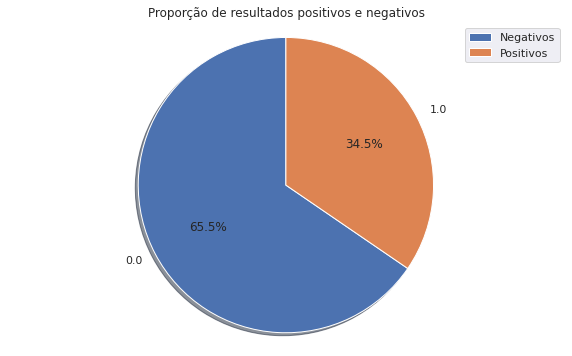

In [ ]:
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.pie(freq, explode=(0, 0), labels=values, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proporção de resultados positivos e negativos")
plt.legend(['Negativos', 'Positivos'])
plt.show(True)

Ou seja, os dados estão desbalanceados: há mais casos negativos do que positivos de diagnóstico de diabetes. Esta é uma observação muito importante, tendo em vista que deveremos utilizar a abordagem de validação cruzada estratificada para escolher os melhores hiperparâmetros dos modelo de classificação.

Observando-se o comportamento dos dados, após a preparação do conjunto de treinamento, temos:

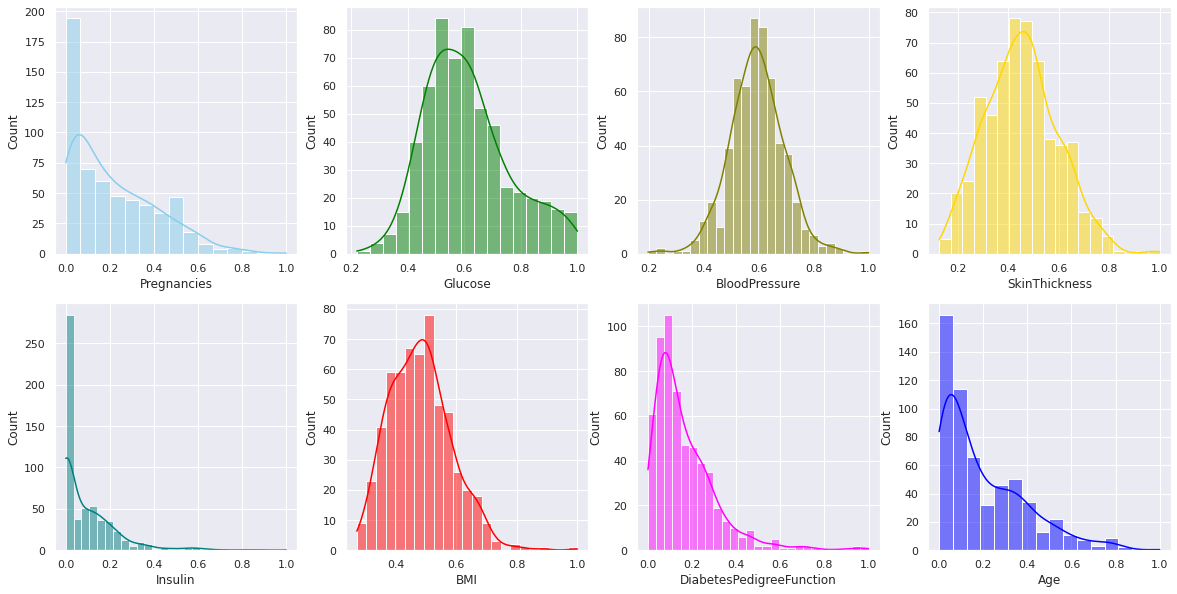

In [ ]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(data=train_norm_final, x="Pregnancies", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=train_norm_final, x="Glucose", kde=True, color="green", ax=axs[0, 1])
sns.histplot(data=train_norm_final, x="BloodPressure", kde=True, color="olive", ax=axs[0, 2])
sns.histplot(data=train_norm_final, x="SkinThickness", kde=True, color="gold", ax=axs[0, 3])
sns.histplot(data=train_norm_final, x="Insulin", kde=True, color="teal", ax=axs[1, 0])
sns.histplot(data=train_norm_final, x="BMI", kde=True, color="red", ax=axs[1, 1])
sns.histplot(data=train_norm_final, x="DiabetesPedigreeFunction", kde=True, color="magenta", ax=axs[1, 2])
sns.histplot(data=train_norm_final, x="Age", kde=True, color="blue", ax=axs[1, 3])

plt.show()

Observando-se as variáveis em relação ao diagnóstico de câncer, tem-se os seguintes Boxplots:

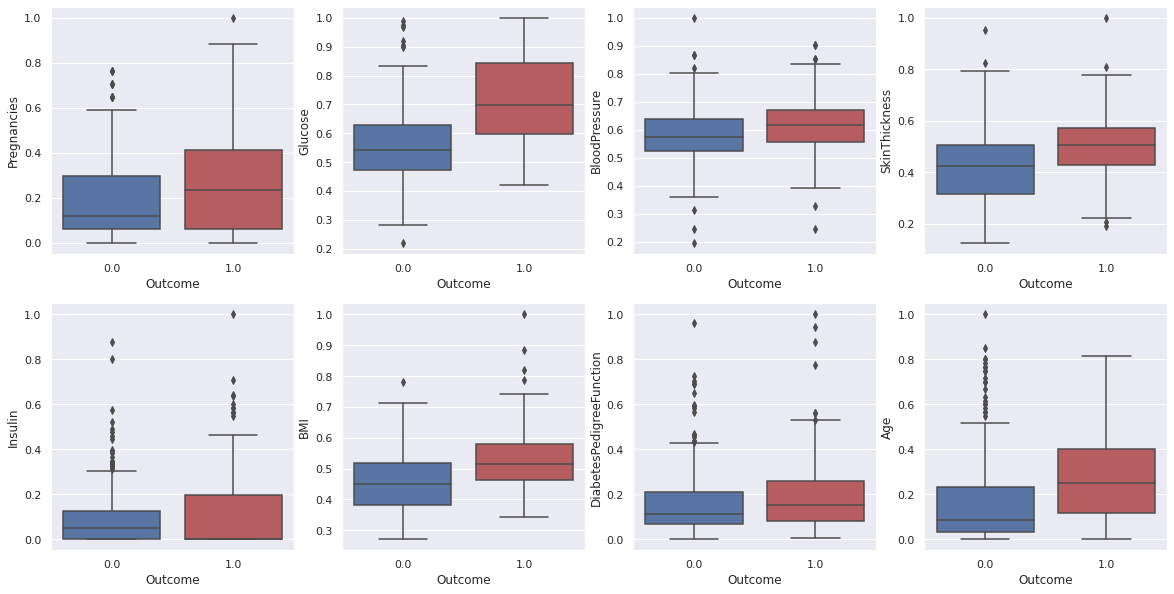

In [ ]:
my_pal = {0: "b", 1:"r"}
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["Pregnancies"], palette=my_pal, ax=axs[0, 0])
sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["Glucose"], palette=my_pal, ax=axs[0, 1])
sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["BloodPressure"], palette=my_pal, ax=axs[0, 2])
sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["SkinThickness"], palette=my_pal, ax=axs[0, 3])
sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["Insulin"], palette=my_pal, ax=axs[1, 0])
sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["BMI"], palette=my_pal, ax=axs[1, 1])
sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["DiabetesPedigreeFunction"], palette=my_pal, ax=axs[1, 2])
sns.boxplot(x=train_norm_final["Outcome"], y=train_norm_final["Age"], palette=my_pal, ax=axs[1, 3])

plt.show()

Pela análise dos boxplots podemos observar como cada variável influencia ou não na ocorrência de diabetes. Aparentemente, apenas as variáveis $BloodPressure$ e $DiabetesPedigreeFunction$ não têm influência na condição médica.

Analisando-se a correlação entre os atributos, segue que:

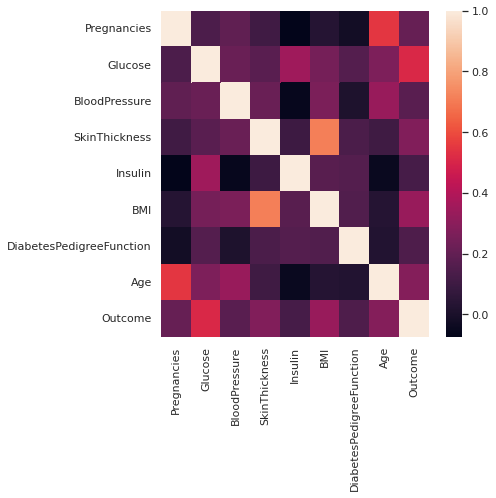

In [ ]:
plt.figure(figsize= (6, 6))
sns.heatmap(train_norm_final.corr())
plt.show(sns)

Nota-se que os atributos não são fortemente correlacionados, porém, observa-se que $BMI$ e $SkinThickness$ têm uma certa correlação próxima de $0,6$. Ou seja, cada atributo carrega consigo sua própria parcela de variância dos dados. 

Considerando que os oito atributos não têm correlação significativa, iremos utilizar todas as oito variáveis para construir os classificadores.

## **5) Métodos de classificação**

Para fazer a classificação, utiliza-se diferentes tipos de classificadores para poder encontrar qual método é o melhor para classificar pacientes com e sem diabetes.

Assim, transformando-se os dados de treinamento e teste finais para o formato do numpy, para facilitar a manipulação, temos:

In [ ]:
train_data = train_norm_final.to_numpy()
nrow1,ncol1 = train_data.shape
y_train = train_data[:,-1]
X_train = train_data[:,0:ncol1-1]

In [ ]:
test_data = test_norm_final.to_numpy()
nrow2,ncol2 = test_data.shape
y_true = test_data[:,-1]
X_test = test_data[:,0:ncol2-1]

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

print('Dados transformados:')
print('Media: ', np.mean(X_train, axis = 0))
print('Desvio Padrao:', np.std(X_train, axis = 0))

print('Dados transformados:')
print('Media: ', np.mean(X_test, axis = 0))
print('Desvio Padrao:', np.std(X_test, axis = 0))

Dados transformados:
Media:  [ 1.32609972e-16 -4.37921304e-16 -4.03997823e-16  4.00913870e-17
  2.46716228e-17  1.63449501e-16 -1.01770444e-16 -5.85951041e-17]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1.]
Dados transformados:
Media:  [-6.47630098e-17 -7.63278329e-17 -3.60822483e-16 -9.94574793e-17
 -4.62592927e-17  5.43546689e-16  8.32667268e-17 -2.59052039e-16]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1.]


Verificando-se a quantidade de positivos e negativos do conjunto de teste, temos:

In [ ]:
positivos = sum(y_true)
negativos = len(y_true) - positivos

print("Positivos: %d" %positivos)
print("Negativos: %d" %negativos)

Positivos: 69
Negativos: 123


Ou seja, assim como no conjunto de treinamento, há mais observações com diagnósticos negativos do que positivos.

Considerando o desbalanceamento dos dados, para avaliar os classificadores serão utilizadas métricas de performance tais como: **precision**, **recall**, e **F1-score**, além do tradicional **accuracy score**.

Além disso, para cada modelo, será obtida a matriz de confusão, na qual retorna o número de **Verdadeiros Positivos (True Positive - TP), Falsos Positivos (False Positive - FP), Verdadeiros Negativos (True Negative - TN)** e **Falsos Negativos (False Negative = FN).**

Ou seja:



*   **True Positive (TP)**: são os resultados que o modelo prevê corretamente como positivos. Os verdadeiros positivos são importantes porque indicam o desempenho do nosso modelo.
*   **False Positive (FP)**: falsos positivos ocorrem quando o modelo prevê que uma observação pertence a uma classe que na verdade não pertence. Por exemplo, em aplicações médicas como é o caso deste trabalho, geralmente é melhor errar por excesso de cautela e ter alguns falsos positivos do que perder totalmente um diagnóstico.
*   **True Negative (TN)**: verdadeiros negativos são os resultados que o modelo prevê corretamente como negativos. Em geral, um alto número de verdadeiros negativos indica que o modelo está funcionando bem.
*   **False Negative (FN)**: falso negativo ocorre quando um modelo prevê uma observação como negativa quando na verdade é positiva. Os falsos negativos costumam ser mais sérios do que os falsos positivos e, portanto, é importante levá-los em consideração ao avaliar o desempenho de um modelo de classificação.



Sendo assim, as métricas são dadas por:

$$Precision \ Score = \dfrac{TP}{(FP + TP)}$$

$$Recall \ score = \dfrac{TP}{(FN + TP)}$$

$$F1 \ score = \dfrac{2 \cdot Precision \ score \cdot Recall \ score}{Precision \ score + Recall \ score}$$


O recall score representa a capacidade do modelo de prever corretamente os positivos dos positivos reais. Isso é diferente da precisão, que mede quantas previsões feitas pelos modelos são realmente positivas de todas as previsões positivas feitas.

Em geral, aumentar a precisão de um modelo diminuirá seu recall e vice-versa. Isso ocorre porque a precisão e o recall estão inversamente relacionados.

Por exemplo, um modelo com alta precisão fará poucas previsões de falsos positivos, mas também pode perder alguns casos de verdadeiros positivos. Por outro lado, um modelo com alto recall identificará corretamente a maioria dos casos verdadeiros positivos, mas também poderá fazer mais previsões falsas positivas.

O F1-Score é uma medida de performance que dá pesos iguais para o recall e precision para medir a performance do modelo em termos de acurácia, isto é, uma alternativa para a accuracy score.

Neste trabalho, escolhemos utilizar o recall score como métrica para avaliar nossos classificadores. A razão disto é que achamos mais importante que os modelos para prever diagnóstico de diabetes tenham a máxima capacidade de acertar todos casos positivos, sendo que estes são os casos mais sensíveis para o médico tratar da saúde do paciente.

Usamos cinco métodos de classificação: regressão logística, K-vizinhos, Naive Bayes, random forest e SVC. Em todos os cinco utilizamos o GridSearch para encontrar os hiperparâmetros para o melhor modelo usando o recall score como métrica de avaliação. Como os dados estão desbalanceados, também utilizamos a validação cruzada estratificada.

### **5.1) Regressão Logística**

Obtendo-se a proporção de diagnósticos positivos e negativos, segue que:

In [ ]:
positive = sum(y_train)/len(y_train)
negative = (len(y_train) - sum(y_train))/len(y_train)

print("Diagnósticos positivos: %.2f" %positive)
print("Diagnósticos negativos: %.2f" %negative)

Diagnósticos positivos: 0.35
Diagnósticos negativos: 0.65


Ou seja, apenas $35\%$ das observações são positivas para o diagnóstico de diabetes. Assim, utilizando-se o método da regressão logística especificando-se o peso de cada classe, temos:

Usando o GridSearch para escolher os hiperparâmetros para o melhor modelo de regressão logística:

In [ ]:
w = {0:65, 1:35} #peso das classes
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
parameters = {'penalty' : ['l1','l2'],
              'C': np.logspace(-3,3,7),
              'solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'max_iter':[1000],
              'class_weight':[w]}

model = LogisticRegression()
best_model_logistic_regression = GridSearchCV(model, parameters, cv = cv, scoring = 'recall')
best_model_logistic_regression.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'class_weight': [{0: 65, 1: 35}], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='recall')

In [ ]:
C, penalty, solver = list(best_model_logistic_regression.best_params_.values())[0],list(best_model_logistic_regression.best_params_.values())[3],list(best_model_logistic_regression.best_params_.values())[4]
print(f'Hiperparâmetros para o melhor modelo de regressão logística: \nC = {C} \npenalty = {penalty} \nsolver = {solver}')

Hiperparâmetros para o melhor modelo de regressão logística: 
C = 0.001 
penalty = l2 
solver = liblinear


In [ ]:
print(f'Recall do melhor modelo no conjunto de treinamento: {best_model_logistic_regression.best_score_}')

Recall do melhor modelo no conjunto de treinamento: 0.4473684210526316


Usamos a matriz de confusão para verificar os acertos e erros do modelo de regressão logística obtido pelo GridSearch:

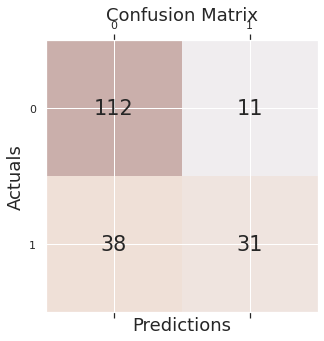

In [ ]:
y_pred_logistic = best_model_logistic_regression.predict(X_test) 

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_logistic)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred_logistic))
print('Precision: %.3f' % precision_score(y_true, y_pred_logistic))
print('Recall: %.3f' % recall_score(y_true, y_pred_logistic))
print('F1 Score: %.3f' % f1_score(y_true, y_pred_logistic))

Accuracy: 0.745
Precision: 0.738
Recall: 0.449
F1 Score: 0.559


Aqui nós percebemos a importância de utilizar diferentes métricas para avaliar um modelo. A matriz de confusão mostra que o classificador de regressão logística consegue acerta a maioria dos diagnósticos negativos, mas como os dados estão desbalanceados, apesar de o modelo ter uma acurácia razoável (0.745), ele tem um recall score bastante baixo (0.449). Isto é um problema, pois significa que o modelo deixa de detectar muitos casos positivos de diabetes (ele retorna muitos falsos negativos).

### **5.2) K-vizinhos**

Fazemos o GridSearch para o classificador K-vizinhos:

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
parameters = {'n_neighbors' : [i for i in range(1,50)],
              'weights' : ['uniform','distance'],
              'metric' : ['euclidean','manhattan']}
model = KNeighborsClassifier()
best_model_knn = GridSearchCV(model, parameters, cv = cv, scoring = 'recall')
best_model_knn.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
metric, n_neighbors, weights = list(best_model_knn.best_params_.values())[0],list(best_model_knn.best_params_.values())[1],list(best_model_knn.best_params_.values())[2]
print(f'Hiperparâmetros para o melhor modelo de KNN usando recall como score: \nmetric = {metric} \nn_neighbors = {n_neighbors} \nweights = {weights}')

Hiperparâmetros para o melhor modelo de KNN usando recall como score: 
metric = manhattan 
n_neighbors = 8 
weights = distance


In [ ]:
print(f'Recall do melhor modelo no conjunto de treinamento: {best_model_knn.best_score_}')

Recall do melhor modelo no conjunto de treinamento: 0.6186842105263157


Fazemos a matriz de confusão para avaliar o modelo de K-vizinhos obtido pelo GridSearch:

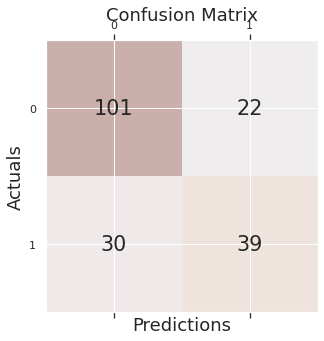

In [ ]:
y_pred_knn = best_model_knn.predict(X_test) 

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_knn)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred_knn))
print('Precision: %.3f' % precision_score(y_true, y_pred_knn))
print('Recall: %.3f' % recall_score(y_true, y_pred_knn))
print('F1 Score: %.3f' % f1_score(y_true, y_pred_knn))

Accuracy: 0.729
Precision: 0.639
Recall: 0.565
F1 Score: 0.600


Percebe-se que o classificador K-vizinhos foi um pouco melhor do que o classificador por regressão logística, considerando o seu recall mais elevado. Porém, ainda não consideramos que é um recall razoável (apenas 56,5% dos casos positivos de diabetes são detectados).

### **5.3) Naive Bayes**

Fazemos o GridSearch para o classificador Naive Bayes:

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
parameters = {'var_smoothing' : np.logspace(0,-9, num=100)}
model = GaussianNB()
best_model_naive_bayes = GridSearchCV(model, parameters, cv = cv, scoring = 'recall')
best_model_naive_bayes.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.3366992...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='recall')

In [ ]:
var_smoothing = list(best_model_naive_bayes.best_params_.values())[0]
print(f'Hiperparâmetro para o melhor modelo de Naive Bayes usando recall como score: \nvar_smoothing = {var_smoothing}')

Hiperparâmetro para o melhor modelo de Naive Bayes usando recall como score: 
var_smoothing = 0.08111308307896872


In [ ]:
print(f'Recall do melhor modelo no conjunto de treinamento: {best_model_naive_bayes.best_score_}')

Recall do melhor modelo no conjunto de treinamento: 0.5978947368421054


Fazemos a matriz de confusão para avaliar o modelo de Naive Bayes obtido pelo GridSearch:

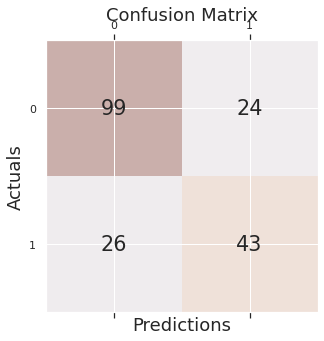

In [ ]:
y_pred_naive_bayes = best_model_naive_bayes.predict(X_test) 

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_naive_bayes)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred_naive_bayes))
print('Precision: %.3f' % precision_score(y_true, y_pred_naive_bayes))
print('Recall: %.3f' % recall_score(y_true, y_pred_naive_bayes))
print('F1 Score: %.3f' % f1_score(y_true, y_pred_naive_bayes))

Accuracy: 0.740
Precision: 0.642
Recall: 0.623
F1 Score: 0.632


O classificador Naive Bayes se mostrou bem melhor do que os dois anteriores para detectar casos positivos de diabetes, como pode ser percebido pelo valor mais elevado de recall. Este modelo conseguiu detectar 62,3% dos casos positivos.

### **5.4) Random Forest**

Fazemos o GridSearch para o classificador Random Forest:

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
parameters = {'n_estimators' : [i for i in range(1,50)],
               'criterion' : ['gini','entropy']}
model = RandomForestClassifier(random_state=42)
best_model_random_forest = GridSearchCV(model, parameters, cv = cv, scoring = 'recall')
best_model_random_forest.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='recall')

In [ ]:
criterion, n_estimators = list(best_model_random_forest.best_params_.values())[0],list(best_model_random_forest.best_params_.values())[1]
print(f'Hiperparâmetros para o melhor modelo de random forest usando recall como score: \ncriterion = {criterion} \nn_estimators = {n_estimators}')

Hiperparâmetros para o melhor modelo de random forest usando recall como score: 
criterion = entropy 
n_estimators = 27


In [ ]:
print(f'Recall do melhor modelo no conjunto de treinamento: {best_model_random_forest.best_score_}')

Recall do melhor modelo no conjunto de treinamento: 0.658421052631579


Fazemos a matriz de confusão para avaliar o modelo de Random Forest obtido pelo GridSearch:

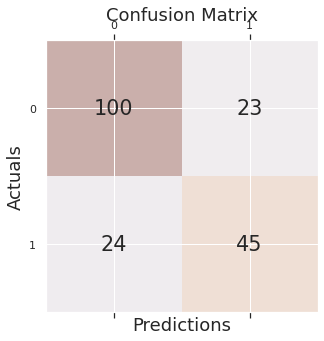

In [ ]:
y_pred_random_forest = best_model_random_forest.predict(X_test) 

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_random_forest)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred_random_forest))
print('Precision: %.3f' % precision_score(y_true, y_pred_random_forest))
print('Recall: %.3f' % recall_score(y_true, y_pred_random_forest))
print('F1 Score: %.3f' % f1_score(y_true, y_pred_random_forest))

Accuracy: 0.755
Precision: 0.662
Recall: 0.652
F1 Score: 0.657


Este classificador usando Random Forest também obteve um recall razoável (0.652), se saindo um pouco melhor do que o classificador Naive Bayes.

Também podemos observar quais variáveis são mais importantes para o modelo de Random Forest:

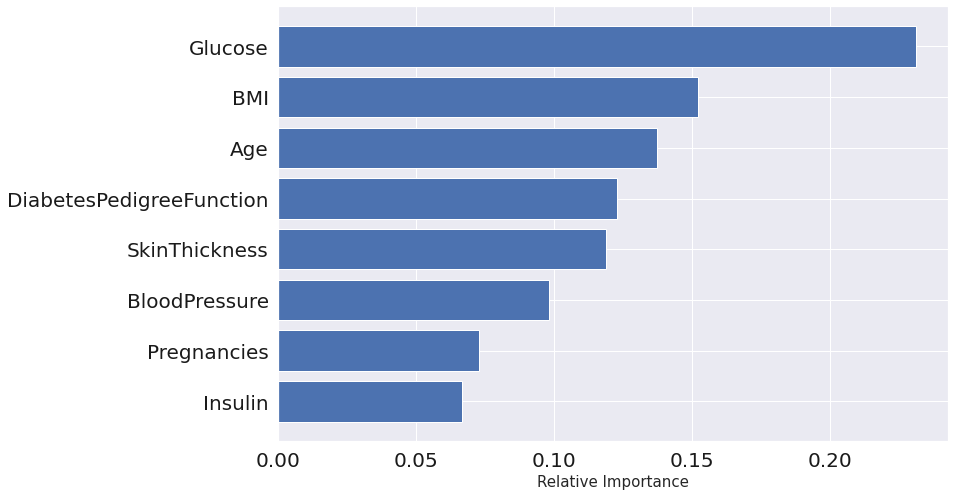

In [ ]:
model = RandomForestClassifier(n_estimators=n_estimators,criterion=criterion,random_state=42)
model.fit(X_train,y_train)

features_names = train_norm_final.columns

importances = model.feature_importances_
indices = np.argsort(importances)
lmeas_order = []
for i in indices:
    lmeas_order.append(features_names[i])
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), lmeas_order, fontsize=15)
plt.xlabel('Relative Importance',fontsize=15)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()

O nível de glicose no sangue se destaca como a variável mais importante para o classificador fazer previsões, ao passo que o nível de insulina, número de vezes que a pessoa engravidou e pressão sanguínea são menos relevantes.

### **5.5) SVC**

Fazemos o GridSearch para o classificador SVC:

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
parameters = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'sigmoid', 'linear']}

model = SVC(probability=True)
best_model_svc = GridSearchCV(model, parameters, cv = cv, scoring = 'recall')
best_model_svc.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             scoring='recall')

In [ ]:
C, gamma, kernel = list(best_model_svc.best_params_.values())[0],list(best_model_svc.best_params_.values())[1],list(best_model_svc.best_params_.values())[2]
print(f'Hiperparâmetros para o melhor modelo de SVC usando recall como score: \nC = {C} \ngamma = {gamma} \nkernel = {kernel}')

Hiperparâmetros para o melhor modelo de SVC usando recall como score: 
C = 10 
gamma = 0.1 
kernel = sigmoid


In [ ]:
print(f'Recall do melhor modelo no conjunto de treinamento: {best_model_svc.best_score_}')

Recall do melhor modelo no conjunto de treinamento: 0.598421052631579


Fazemos a matriz de confusão para avaliar o modelo de SVC obtido pelo GridSearch:

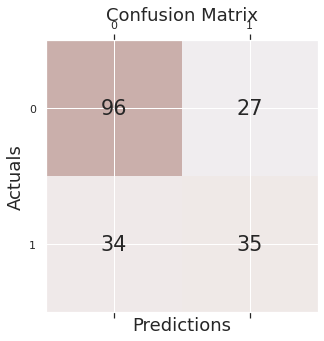

In [ ]:
y_pred_svc = best_model_svc.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_svc)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred_svc))
print('Precision: %.3f' % precision_score(y_true, y_pred_svc))
print('Recall: %.3f' % recall_score(y_true, y_pred_svc))
print('F1 Score: %.3f' % f1_score(y_true, y_pred_svc))

Accuracy: 0.682
Precision: 0.565
Recall: 0.507
F1 Score: 0.534


Este classificador se mostrou pouco eficiente para detectar casos positivos de diabetes, com um recall score de apenas 0.507.

## **6) Comparação dos modelos de classificação**

A curva ROC é um gráfico que mostra a relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos de um modelo de classificação.

A área sob a curva ROC (AUC) é uma métrica que quantifica o desempenho geral do modelo. Um modelo com uma AUC mais alta é considerado um melhor classificador. 

Utilizaremos a AUC em conjunto com o recall score para fazer a avaliação dos modelos, uma vez que é importante haver um balanço entre detectar o máximo possível dos verdadeiros positivos (avaliado pelo recall score) e gerar o mínimo de transtorno a pacientes que são diagnosticados com falsos positos (avaliado pelo AUC).

In [ ]:
# predict probabilities
pred_prob_logistic = best_model_logistic_regression.predict_proba(X_test)
pred_prob_knn = best_model_knn.predict_proba(X_test)
pred_prob_naive_bayes = best_model_naive_bayes.predict_proba(X_test)
pred_prob_random_forest = best_model_random_forest.predict_proba(X_test)
pred_prob_svc = best_model_svc.predict_proba(X_test)

In [ ]:
# roc curve for models
fpr_logistic, tpr_logistic, thresh_logistic = roc_curve(y_true, pred_prob_logistic[:,1], pos_label=1)
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_true, pred_prob_knn[:,1], pos_label=1)
fpr_naive_bayes, tpr_naive_bayes, thresh_naive_bayes = roc_curve(y_true, pred_prob_naive_bayes[:,1], pos_label=1)
fpr_random_forest, tpr_random_forest, thresh_random_forest = roc_curve(y_true, pred_prob_random_forest[:,1], pos_label=1)
fpr_svc, tpr_svc, thresh_svc = roc_curve(y_true, pred_prob_svc[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_true))]
p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)

In [ ]:
# auc scores
auc_score_logistic = roc_auc_score(y_true, pred_prob_logistic[:,1])
auc_score_knn = roc_auc_score(y_true, pred_prob_knn[:,1])
auc_score_naive_bayes = roc_auc_score(y_true, pred_prob_naive_bayes[:,1])
auc_score_random_forest = roc_auc_score(y_true, pred_prob_random_forest[:,1])
auc_score_svc = roc_auc_score(y_true, pred_prob_svc[:,1])

print("AUC scores:")
print("Regressão Logística: ", auc_score_logistic)
print("K-vizinhos: ", auc_score_knn)
print("Naive Bayes: ", auc_score_naive_bayes)
print("Random Forest: ", auc_score_random_forest)
print("SVC: ", auc_score_svc)

AUC scores:
Regressão Logística:  0.8005184399670083
K-vizinhos:  0.7641687286438081
Naive Bayes:  0.8069989395546129
Random Forest:  0.8201955932602805
SVC:  0.7053140096618357


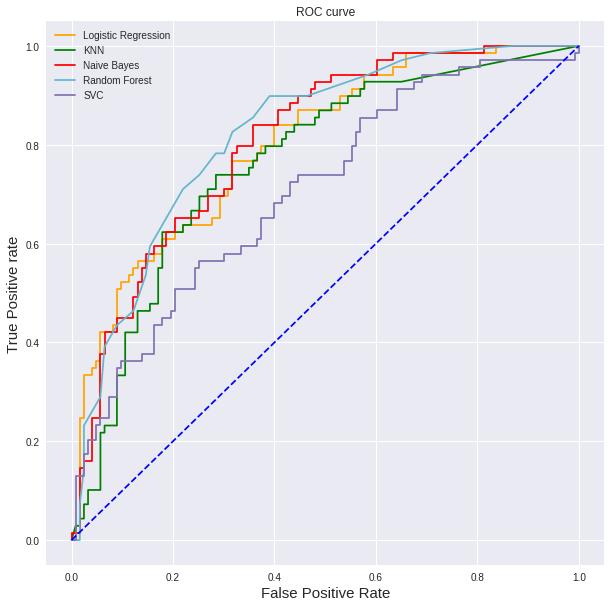

In [ ]:
# plot roc curves

plt.style.use('seaborn')

plt.figure(figsize=(10,10))
plt.plot(fpr_logistic, tpr_logistic, linestyle='-',color='orange', label='Logistic Regression')
plt.plot(fpr_knn, tpr_knn, linestyle='-',color='green', label='KNN')
plt.plot(fpr_naive_bayes, tpr_naive_bayes, linestyle='-',color='red', label='Naive Bayes')
plt.plot(fpr_random_forest, tpr_random_forest, linestyle='-',color='c', label='Random Forest')
plt.plot(fpr_svc, tpr_svc, linestyle='-',color='m', label='SVC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive rate', fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(loc='best')
plt.show();

O valores de AUC e o gráfico acima mostram que o classificador por Random Forest tem o melhor desempenho para alcançar o nosso objetivo de diagnosticar casos de diabetes. Um valor de AUC de 0.820 mostra que o modelo de Random Forest é o mais efetivo em detectar verdadeiros positivos minimizando falsos positivos.

## **7) Resultados finais e conclusões**

In [ ]:
data = {'Recall score': [recall_score(y_true, y_pred_logistic),
                         recall_score(y_true, y_pred_knn),
                         recall_score(y_true, y_pred_naive_bayes),
                         recall_score(y_true, y_pred_random_forest),
                         recall_score(y_true, y_pred_svc)],
        'AUC score': [auc_score_logistic,
                auc_score_knn,
                auc_score_naive_bayes,
                auc_score_random_forest,
                auc_score_svc]}
 
resultados = pd.DataFrame(data, index=['Regressão logística',
                                       'K-vizinhos',
                                       'Naive Bayes',
                                       'Random Forest',
                                       'SVC'])

print('Resumo dos resultados')
resultados

Resumo dos resultados


,Recall score,AUC score
Regressão logística,0.449275,0.800518
K-vizinhos,0.565217,0.764169
Naive Bayes,0.623188,0.806999
Random Forest,0.652174,0.820196
SVC,0.507246,0.705314


A tabela com o resumo dos resultados para os cinco classificadores indica que o modelo de Random Forest otimizado pelo GridSearch tem tanto o melhor recall score quanto o melhor AUC score.

Entretanto, devemos considerar que a complexidade do problema não foi nem de longe resolvida por completo. Um recall score de 0.652 é muito baixo para que um profissional da saúde confie inteiramente nas previsões do modelo. A utilidade deste modelo de Random Forest reside em gerar alertas de possíveis situações de risco médico, não em descartar a necessidade de exames clínicos.

Os resultados dos cinco modelos ainda podem ser melhorados. Um ponto crítico é a correção de dados faltantes. Utilizamos regressão linear múltipla com todas as covariáveis e considerando apenas relação de primeiro grau. Entretanto, algumas covariáveis não têm relevância estatística e pode haver termos cruzados ou de graus maiores. Uma vez que uma grande quantidade de valores foram substituídos por regressão linear, se obtermos modelos de regressão melhores, os resultados dos classificadores poderão ser substancialmente melhorados.

O gráfico que mostra a relevância de atributos no modelo de Random Forest ilustra muito bem este ponto. Espessura da pele é um atributo com importância moderadamente alta, mas tivemos que substituir cerca de 200 dos seus valores (de um total de 768). Ajustar um modelo ótimo para substituir seus valores potencialmente levará a previsões melhores.

Além disso, o modelo de Random Forest também indicou que as variáveis $Insulin$, $Pregnancies$ e $BloodPressure$ têm relevância baixa em comparação a todas as outras. É possível descartar estas variáveis sem que o modelo tenha uma perda substancial em seu desempenho. Isto é importante caso se deseje melhorar a interpretabilidade do modelo (para buscar a razão de um diagnóstico positivo, por exemplo), ou caso se deseje melhorar o modelo focando apenas nas variáveis importantes.